# Packages & functions

In [24]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
from tensorflow.keras import models

from tensorflow.keras.layers import Conv2D as Conv2D
from tensorflow.keras.layers import BatchNormalization as BatchNormalization
from tensorflow.keras.layers import ReLU as ReLU
from tensorflow.keras.layers import MaxPool2D as MaxPool2D
from tensorflow.keras.layers import Flatten as Flatten
from tensorflow.keras.layers import Dense as Dense

from os.path import isdir
import os
import numpy as np

from sklearn.model_selection import train_test_split

# Plotting
import seaborn as sns

In [70]:
class DataProperties:
    train_data_path = '/content/drive/MyDrive/UNIPD/HDA/Project/TrainData/'
    test_data_path = '/content/drive/MyDrive/UNIPD/HDA/Project/TestData/'
    
    train_covid_path = train_data_path + 'covid/'
    train_pneumonia_path = train_data_path + 'pneumonia/'
    train_healthy_path = train_data_path + 'normal/'

    test_covid_path = test_data_path + 'covid/'
    test_pneumonia_path = test_data_path + 'pneumonia/'
    test_healthy_path = test_data_path + 'normal/'

    healthy_class = 0
    covid_class = 1
    pneumonia_class = 2

class TrainParameters:
    train_size = 0.8
    random_state = 123
    batch_size = 32
    max_size = 50  # Max size of each class

class PreprocParameters:
    resize_shape = (300, 300)

# Data download

## Paths download

In [68]:
# Load filenames
def load_filenames(data_path, max_files = None):
    p = os.listdir(data_path)
    if max_files is not None:
        p = p[: min(max_files, len(p))]
    p = [data_path + file_path for file_path in p]
    return p

def get_filenames(
    covid_path, pneumonia_path, normal_path
):
    return (
        load_filenames(covid_path),
        load_filenames(pneumonia_path),
        load_filenames(normal_path)
    )

In [73]:
train_covid_fnames, train_pn_fnames, train_normal_fnames = get_filenames(
    covid_path = DataProperties.train_covid_path,
    pneumonia_path = DataProperties.train_pneumonia_path,
    normal_path = DataProperties.train_healthy_path
)

test_covid_fnames, test_pn_fnames, test_normal_fnames = get_filenames(
    covid_path = DataProperties.test_covid_path,
    pneumonia_path = DataProperties.test_pneumonia_path,
    normal_path = DataProperties.test_healthy_path
)

#covid_fnames = load_filenames(DataProperties.covid_path)#, TrainParameters.max_size)
#pn_fnames = load_filenames(DataProperties.pneumonia_path)#, TrainParameters.max_size)
#healthy_fnames = load_filenames(DataProperties.healthy_path)#, TrainParameters.max_size)

In [74]:
def get_labels(
    covid_fnames,
    pn_fnames,
    normal_fnames
):
    return (
        np.full(len(covid_fnames), fill_value = DataProperties.covid_class),
        np.full(len(pn_fnames), fill_value = DataProperties.pneumonia_class),
        np.full(len(normal_fnames), fill_value = DataProperties.healthy_class)
    )

train_covid_labels, train_pn_labels, train_normal_labels = get_labels(
    train_covid_fnames,
    train_pn_fnames,
    train_normal_fnames
)

test_covid_labels, test_pn_labels, test_normal_labels = get_labels(
    test_covid_fnames,
    test_pn_fnames,
    test_normal_fnames
)

# train_covid_labels = np.full(
#     len(covid_fnames), fill_value = DataProperties.covid_class
# )

# train_pn_labels = np.full(
#     len(pn_fnames), fill_value = DataProperties.pneumonia_class
# )

# train_normal_labels = np.full(
#     len(healthy_fnames), fill_value = DataProperties.healthy_class
# )

In [75]:
def getXY(covid_fnames, pn_fnames, normal_fnames,
          covid_labels, pn_labels, normal_labels):
    X = [
         *covid_fnames, *pn_fnames, *normal_fnames
    ]
    Y = [
         *covid_labels, *pn_labels, *normal_labels
    ]
    return X, Y

X_train_val, Y_train_val = getXY(
    train_covid_fnames, train_pn_fnames, train_normal_fnames,
    train_covid_labels, train_pn_labels, train_normal_labels
)

X_test, Y_test = getXY(
    test_covid_fnames, test_pn_fnames, test_normal_fnames,
    test_covid_labels, test_pn_labels, test_normal_labels
)

## Split

In [64]:
# X_train, X_test, Y_train, Y_test = train_test_split(
#     X, Y,
#     train_size = TrainParameters.train_size,
#     random_state = TrainParameters.random_state,
#     stratify = Y
# )

# Data exploration

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


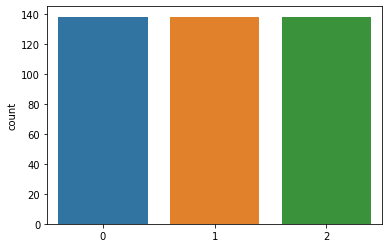

In [76]:
_ = sns.countplot(Y_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


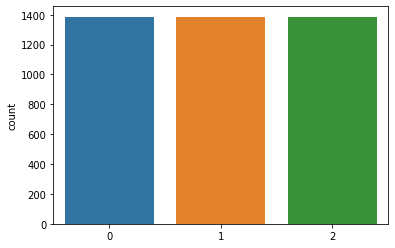

In [77]:
_ = sns.countplot(Y_train_val)

In [78]:
def load_image(full_path):
    print(f'Loading, {full_path}')
    img = cv2.imread(full_path, cv2.IMREAD_COLOR)
    print(type(img))
    return img

/content/drive/MyDrive/UNIPD/HDA/Project/TrainData/covid/COVID-19 (401).jpg
Loading, /content/drive/MyDrive/UNIPD/HDA/Project/TrainData/covid/COVID-19 (401).jpg
<class 'numpy.ndarray'>


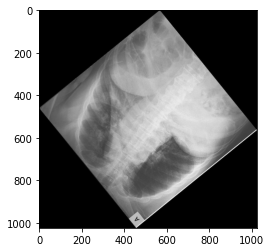

In [80]:
print(X[0])
im = load_image(X_train_val[0])
plt.imshow(im.astype('uint8'))

# Creating dataset

In [88]:
img_height, img_width = PreprocParameters.resize_shape 
batch_size = 32
seed = 123
validation_split = 0.2
shuffle_train = True
shuffle_validation = True
shuffle_test = True


def get_dataset(
    path,
    batch_size,
    image_size,
    shuffle,
    seed,
    subset,
    validation_split = None
):  

    ds = tf.keras.preprocessing.image_dataset_from_directory(
        path,
        labels = 'inferred',
        label_mode = 'int',
        color_mode = 'rgb',
        batch_size = batch_size,
        image_size = image_size,
        shuffle = shuffle,
        seed = seed,
        validation_split = validation_split,
        subset = subset
    )

    #ds = ds.repeat()
    return {
        'class names': ds.class_names,
        'data': ds.cache().prefetch(
            buffer_size = tf.data.experimental.AUTOTUNE
        )
    }
    
ds_train = get_dataset(
    path = DataProperties.train_data_path,
    batch_size = batch_size,
    image_size = PreprocParameters.resize_shape,
    shuffle = shuffle_train,
    seed = seed,
    subset = 'training',
    validation_split = validation_split
)

ds_validation = get_dataset(
    path = DataProperties.train_data_path,
    batch_size = batch_size,
    image_size = PreprocParameters.resize_shape,
    shuffle = shuffle_validation,
    seed = seed,
    subset = 'validation',
    validation_split = validation_split
)

ds_test = get_dataset(
    path = DataProperties.test_data_path,
    batch_size = batch_size,
    image_size = PreprocParameters.resize_shape,
    shuffle = shuffle_test,
    seed = seed,
    subset = None,
    validation_split = None
)

# ds_train = tf.keras.preprocessing.image_dataset_from_directory(
#     DataProperties.train_data_path,
#     labels = 'inferred',
#     label_mode = 'int',
#     color_mode = 'rgb',
#     batch_size = batch_size,
#     image_size = (img_height, img_width),
#     shuffle = shuffle_train,
#     seed = seed,
#     validation_split = validation_split,
#     subset = 'training'
# )

# ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
#     DataProperties.train_data_path,
#     labels = 'inferred',
#     label_mode = 'int',
#     # class_names = ,
#     color_mode = 'rgb',
#     batch_size = batch_size,
#     image_size = (img_height, img_width),
#     shuffle = shuffle_test,
#     seed = seed,
#     validation_split = validation_split,
#     subset = 'validation'
# )

Found 4161 files belonging to 3 classes.
Using 3329 files for training.
Found 4161 files belonging to 3 classes.
Using 832 files for validation.
Found 414 files belonging to 3 classes.


In [40]:
# ds_train = ds_train.repeat()
# ds_validation = ds_validation.repeat()

# ds_train = ds_train.prefetch(buffer_size = 1)
# ds_validation = ds_validation.prefetch(buffer_size = 1)

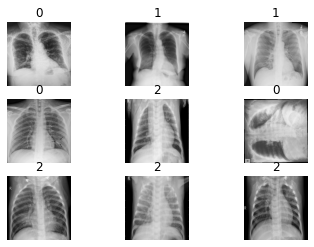

In [85]:
for images, labels in ds_train.take(1):
    for i in range(9): #(batch_size):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(str(labels[i].numpy()))
        plt.axis("off")

In [86]:
# def print_max_pix_val(ds):
#     for images, labels in ds.take(1):
#         for i in range(batch_size):
#             print(np.max(images[i].numpy()))
#             print(images[i].numpy().shape)

# print_max_pix_val(ds_train)
# print_max_pix_val(ds_validation)

In [93]:
!pip install nose

     |████████████████████████████████| 154 kB 8.9 MB/s 


In [96]:
# testing
from nose.tools import assert_equal

assert_equal(ds_train['class names'], ds_test['class names'])
assert_equal(ds_train['class names'], ds_validation['class names'])

In [97]:
ds_train['class names']

['covid', 'normal', 'pneumonia']

In [99]:
image_dir = DataProperties.train_data_path + class_names[0]
image_dir

'/content/drive/MyDrive/UNIPD/HDA/Project/TrainData/covid'

In [102]:
from os import listdir

listdir(image_dir)[0]

'COVID-19 (401).jpg'

n_classes = 3
class name: covid
Full dir: /content/drive/MyDrive/UNIPD/HDA/Project/TrainData/covid
Loading, /content/drive/MyDrive/UNIPD/HDA/Project/TrainData/covid/COVID-19 (401).jpg
<class 'numpy.ndarray'>
Loading, /content/drive/MyDrive/UNIPD/HDA/Project/TrainData/covid/COVID-19 (526).jpg
<class 'numpy.ndarray'>
Loading, /content/drive/MyDrive/UNIPD/HDA/Project/TrainData/covid/COVID-19 (430).jpg
<class 'numpy.ndarray'>
class name: normal
Full dir: /content/drive/MyDrive/UNIPD/HDA/Project/TrainData/normal
Loading, /content/drive/MyDrive/UNIPD/HDA/Project/TrainData/normal/00000376_003.png
<class 'numpy.ndarray'>
Loading, /content/drive/MyDrive/UNIPD/HDA/Project/TrainData/normal/00000366_000.png
<class 'numpy.ndarray'>
Loading, /content/drive/MyDrive/UNIPD/HDA/Project/TrainData/normal/00000380_000.png
<class 'numpy.ndarray'>
class name: pneumonia
Full dir: /content/drive/MyDrive/UNIPD/HDA/Project/TrainData/pneumonia
Loading, /content/drive/MyDrive/UNIPD/HDA/Project/TrainData/pneumonia/

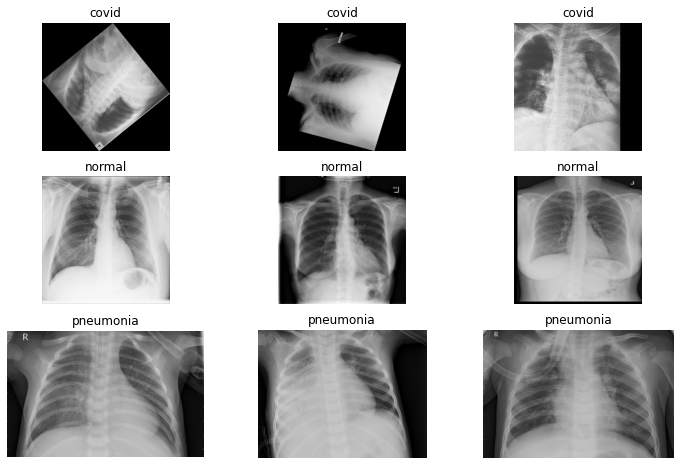

In [126]:
train_class_names = ds_train['class names']
n_classes = len(train_class_names)
print(f'n_classes = {n_classes}')
n_plot = 3


fig, axes = plt.subplots(n_classes, n_plot, figsize = (12, 8))

for i, class_name in enumerate(class_names):
    # print(f'class name: {class_name}')
    full_dir = DataProperties.train_data_path + class_name
    # print(f'Full dir: {full_dir}')
    images_full_dirs = listdir(full_dir)[: n_plot]
    # print(images_full_dirs)
    images = [load_image(full_dir + '/' + dir) for dir in images_full_dirs]

    for j, image in enumerate(images):
        axes[i, j].imshow(image)
        axes[i, j].axis('off')
        axes[i, j].set_title(class_name)

# Data preprocessing

## Normalization

In [43]:
def normalize_image(image, y):
    return tf.cast(image, tf.float32) / 255., y

In [44]:
ds_train = ds_train.map(normalize_image)
ds_validation = ds_validation.map(normalize_image)

In [45]:
print_max_pix_val(ds_train)
print_max_pix_val(ds_validation)

0.9997136
(300, 300, 3)
0.96408623
(300, 300, 3)
0.9998742
(300, 300, 3)
0.9960781
(300, 300, 3)
1.0
(300, 300, 3)
0.99727815
(300, 300, 3)
0.9397453
(300, 300, 3)
0.99270594
(300, 300, 3)
0.99864054
(300, 300, 3)
0.9918967
(300, 300, 3)
1.0
(300, 300, 3)
0.999181
(300, 300, 3)
1.0
(300, 300, 3)
0.9998235
(300, 300, 3)
1.0
(300, 300, 3)
0.97252375
(300, 300, 3)
1.0
(300, 300, 3)
0.7601132
(300, 300, 3)
0.9997019
(300, 300, 3)
0.7470588
(300, 300, 3)
0.97286123
(300, 300, 3)
1.0
(300, 300, 3)
0.80944
(300, 300, 3)
0.999628
(300, 300, 3)
0.9827944
(300, 300, 3)
1.0
(300, 300, 3)
0.9958203
(300, 300, 3)
0.9434246
(300, 300, 3)
0.9017804
(300, 300, 3)
1.0
(300, 300, 3)
0.99639225
(300, 300, 3)
1.0
(300, 300, 3)
0.7687635
(300, 300, 3)
0.99967325
(300, 300, 3)
0.9997908
(300, 300, 3)
0.9775121
(300, 300, 3)
0.9986928
(300, 300, 3)
1.0
(300, 300, 3)
0.9715248
(300, 300, 3)
0.97963035
(300, 300, 3)
0.998033
(300, 300, 3)
0.9993333
(300, 300, 3)
0.991004
(300, 300, 3)
0.99979645
(300, 300, 3)


# CNN

In [46]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(3))

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 322624)            0

In [48]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [52]:
len(X_train), len(X_test)

(120, 30)

In [53]:
train_steps = int(np.ceil(len(X_train) / batch_size))
test_steps = int(np.ceil(len(X_test) / batch_size))

In [54]:
history = model.fit(
    ds_train,  # ds_validation,
    epochs = 10,
    steps_per_epoch = train_steps,
    validation_steps = test_steps,
    validation_data = ds_validation,
    verbose = 2
)

Epoch 1/10
4/4 - 31s - loss: 7.1276 - accuracy: 0.4219 - val_loss: 1.6635 - val_accuracy: 0.4375 - 31s/epoch - 8s/step
Epoch 2/10
4/4 - 25s - loss: 1.2634 - accuracy: 0.3203 - val_loss: 0.9423 - val_accuracy: 0.5938 - 25s/epoch - 6s/step
Epoch 3/10
4/4 - 25s - loss: 0.9788 - accuracy: 0.5469 - val_loss: 1.1933 - val_accuracy: 0.4688 - 25s/epoch - 6s/step
Epoch 4/10
4/4 - 25s - loss: 1.0601 - accuracy: 0.5469 - val_loss: 0.7833 - val_accuracy: 0.7188 - 25s/epoch - 6s/step
Epoch 5/10
4/4 - 26s - loss: 0.8130 - accuracy: 0.6484 - val_loss: 0.7009 - val_accuracy: 0.7812 - 26s/epoch - 6s/step
Epoch 6/10
4/4 - 25s - loss: 0.6383 - accuracy: 0.7422 - val_loss: 0.5802 - val_accuracy: 0.8438 - 25s/epoch - 6s/step
Epoch 7/10
4/4 - 25s - loss: 0.5039 - accuracy: 0.8125 - val_loss: 0.3937 - val_accuracy: 0.8438 - 25s/epoch - 6s/step
Epoch 8/10
4/4 - 25s - loss: 0.6772 - accuracy: 0.7266 - val_loss: 0.7272 - val_accuracy: 0.7812 - 25s/epoch - 6s/step
Epoch 9/10
4/4 - 25s - loss: 0.3974 - accuracy: 

In [55]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

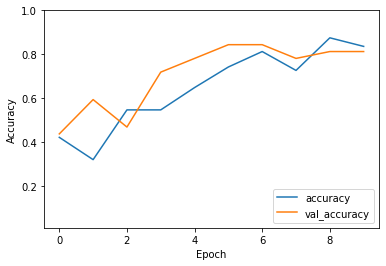

In [57]:
plt.plot(history.history['accuracy'], label='accuracy')

plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.01, 1])
plt.legend(loc='lower right')

In [58]:
test_loss, test_acc = model.evaluate(ds_validation, verbose = 2)  # (ds_train, verbose=2)
print(test_acc)

ValueError: ignored

## Other stuff

In [ ]:
def LOAD_IMAGE(full_path):
    print(f'Loading, {full_path}')
    file = tf.io.read_file(full_path)
    extension = full_path[-3:]
    if extension == 'jpg':
        image_decoded = tf.io.decode_jpeg(file, channels=3)
        image = tf.cast(image_decoded, tf.float32)
        
    if extension == 'png':
        image_decoded = tf.io.decode_jpeg(file, channels=3)
        image = tf.cast(image_decoded, tf.float32)
    else:
        image_decoded = tf.io.decode_jpeg(file, channels=3)
        image = tf.cast(image_decoded, tf.float32)
    return image

def resize_image(image, new_shape):
    n = cv2.resize(image, new_shape)
    return n

def normalize_image(image):
    return tf.cast(image, tf.float32) / 255.


def create_dataset(file_names, shuffle, cache_file):
    dataset = tf.data.Dataset.from_tensor_slices(
        file_names
    )

    # load image func
    load_im = lambda full_path: (
        tf.numpy_function(LOAD_IMAGE, [full_path], tf.float32)
    )

    # # resize
    # resize_im = lambda image: (
    #     tf.numpy_function(
    #         resize_image, 
    #         [image, PreprocParameters.resize_shape], 
    #         tf.float32
    #     )
    # )

    # # normalize
    # normalize_im = lambda image: (
    #     tf.numpy_function(
    #         normalize_image,
    #         [image],
    #         tf.float32
    #     )
    # )

    dataset = dataset.map(load_im, num_parallel_calls = os.cpu_count())
    # dataset = dataset.map(resize_im, num_parallel_calls = os.cpu_count())
    # dataset = dataset.map(normalize_im, num_parallel_calls = os.cpu_count())

    # Cache dataset
    if cache_file:
        dataset = dataset.cache(cache_file)

    # Shuffle
    #if shuffle:
    #    dataset = dataset.shuffle(len(file_names))

    # Repeat the dataset indefinitely
    # dataset = dataset.repeat()

    # Batch
    # dataset = dataset.batch(
     #   batch_size = TrainParameters.batch_size
    #)

    # Prefetch
    #dataset = dataset.prefetch(buffer_size = 1)

    return dataset

In [ ]:
train_dataset = create_dataset(
    X_train,
    shuffle = True,
    cache_file = None # 'train_cache'
)

test_dataset = create_dataset(
    X_test,
    shuffle = True,
    cache_file = None # 'test_cache'
)

# CNN model

In [ ]:
train_dataset.take(2)

<TakeDataset shapes: <unknown>, types: tf.float32>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loading, b'/content/drive/MyDrive/UNIPD/HDA/Project/Data/covid/COVID-19 (527).jpg'
Loading, b'/content/drive/MyDrive/UNIPD/HDA/Project/Data/normal/00000419_000.png'
Loading, b'/content/drive/MyDrive/UNIPD/HDA/Project/Data/covid/COVID-19 (408).jpg'
Loading, b'/content/drive/MyDrive/UNIPD/HDA/Project/Data/normal/00000366_001.png'
Loading, b'/content/drive/MyDrive/UNIPD/HDA/Project/Data/normal/00000370_007.png'
Loading, b'/content/drive/MyDrive/UNIPD/HDA/Project/Data/pneumonia/person1313_bacteria_3320.jpeg'
Loading, b'/content/drive/MyDrive/UNIPD/HDA/Project/Data/normal/00000427_001.png'


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


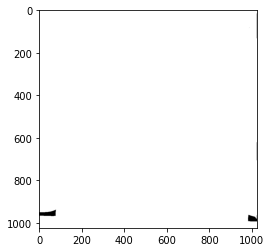

In [ ]:
for im in train_dataset.take(5):
    plt.imshow(im)